# VinDsl.jl: Fast and furious statistical modeling
 
<img src="http://pearsonlab.github.io/images/plab_hex_icon_gray.png" width="150", align="left", style="float:left">
<img src="dibs-logo-small.png" width="350", align="left", style="float:right">

<br>
John Pearson  
P[&lambda;]ab  
Duke Institute for Brain Sciences



# About me

<img src="http://pearsonlab.github.io/images/plab_logo_dark.svg" width="400">

- computational neuroscience lab at Duke
- using Julia for about a year
- member of JuliaStats organization

# Our problem  
  
<figure style="display:inline-block;font-size:50%;float:left">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6a/Monkey_grooming_02.JPG/640px-Monkey_grooming_02.JPG" width=400 align=left>
<figcaption>By AKS.9955, via Wikimedia Commons</figcaption>
</figure>

<figure style="display:inline-block;font-size:50%;float:right;text-align:center">
<img src="https://praneethnamburi.files.wordpress.com/2015/02/02_raster_baselineandstim.png" width=400 align=right>
<figcaption>https://praneethnamburi.wordpress.com/2015/02/05/simulating-neural-spike-trains/</figcaption>
</figure>


# Our problem

- model responses to known features (like GLM)
- infer latent features
- do this scalably for large populations of neurons
- use (generative) Bayesian models that account for uncertainty

# One solution: Sampling

- Markov Chain Monte Carlo (MCMC) methods come with guarantees about correctness
- lots of packages (Lora.jl, Mamba.jl, Stan.jl)
- **But** sampling does not scale well to millions of observations and parameters

# Another solution: The Max Power Way

<img src="max_power.jpg" width="600">

# Variational Bayesian Inference (VB)

Generative model for data: $p(y|\theta)p(\theta)$  
Actual posterior: $p(\theta|y) = p(y|\theta)p(\theta)/p(y)$  
Approximate posterior: $q(\theta)$  

Maximize **E**vidence **L**ower **Bo**und (ELBO) wrt $\theta$:

$$
\mathcal{L} = \log p(y) \ge -KL\left(q \middle\| p\right) = \mathbb{E}_q[\log p(y|\theta)] + \mathcal{H}[q]
$$

- $\mathbb{E}_q[\log p(y|\theta)]$ measures goodness of fit (data likely under approximate posterior)
- $\mathcal{H}[q]$ is the entropy (favors less certain models)

# Why VB?

- Scales well
- Can use well-studied optimization techniques

# Drawbacks:
- !@$*&# hard to code
- Can't quickly spec out a model like with Stan or JAGS/BUGS
- Traditionally, requires that distributions be conjugate, requires doing lots of algebra

# But VB is exploding!

- stochastic variational inference (SVI): [Hoffman et al.](http://dl.acm.org/citation.cfm?id=2502622)
- black box variational inference (BBVI): [Ranganath et al.](http://arxiv.org/abs/1401.0118)
- control variates: [Paisley et al.](http://arxiv.org/abs/1206.6430)
- local expectation gradients (LEG): [Titsias and L&aacute;zaro-Gredilla](http://papers.nips.cc/paper/5678-local-expectation-gradients-for-black-box-variational-inference)
- neural variational inference (NVIL): [Mnih and Gregor](http://arxiv.org/abs/1402.0030)
- variational autoencoders [Kingma and Welling](http://arxiv.org/abs/1312.6114), [Rezende et al.](http://arxiv.org/abs/1401.4082) 

# What's out there

- research code: individual algorithms, proof of concept 
- [Stan](http://mc-stan.org/) 
    - **Pros**: Robust, actively developed, good with stats, accessible from Julia
    - **Cons**: variational methods still experimental, C++
    

- [Edward](https://github.com/blei-lab/edward)
    - **Pros**: Python, multiple backends, from Stan and VB core developers
    - **Cons**: Python, very new


# What's out there
- [Theano](http://deeplearning.net/software/theano/) & [TensorFlow](https://www.tensorflow.org/)
    - **Pros**: well-tested, stable, well-engineered backends
    - **Cons**: complex, C++, not very stats-aware


# What do we want?
- write math, get code &mdash; a domain-specific language (DSL)
- easily generalize to different numbers of indices, structures
- only weakly opinionated about model structure or inference
- model code should be *hackable*
    - easy to use prefab pieces
    - not hard to write custom VB tricks
    - fast prototyping
- no (or minimal) algebra
- automatic gradients

Introducing...
![](http://www.joblo.com/newsimages1/vin.diesel_1920x1200_961)
## VinDsl.jl: Fast and furious variational inference

# What's the goal?
- quick prototyping
- targeted at researchers
- "internal" DSL
- loosely-coupled parts
- "consenting adults" philosophy

# Today: two prototypes
- "Classical" models (conjugate + some optimization)
- ADVI "Black Box" models

# Model 1

### Finally, some code!

In [1]:
using Distributions
using VinDsl

# Model structure:
### Main idea: Factor graphs
- idea from Dahua Lin in [this talk](http://people.csail.mit.edu/dhlin/jubayes/julia_bayes_inference.pdf)
<img src="http://research.microsoft.com/en-us/um/people/cmbishop/prml/prmlfigs-png/Figure8.51.png" width="200">
- Nodes: arrays of distributions
- Factors $\leftrightarrow$ terms in variational objective
    - but not locked in to graphical model structure!

In [2]:
dims = (20, 6)

μ[j] ~ Normal(zeros(dims[2]), ones(dims[2]))
τ[j] ~ Gamma(1.1 * ones(dims[2]), ones(dims[2]))
μ0[j] ~ Const(zeros(dims[2]))

y[i, j] ~ Const(rand(dims));

Nodes: under the hood
nodes define the q/approximate posterior/recognition model
~ defines a node
can use any distribution defined in the Distributions package
code parses the left and right-hand sides
indices on left get tracked and assigned to dimensions of parameter arrays
code is rewritten as a call to a node constructor

In [3]:
f = @factor LogNormalFactor y μ τ;

or...

In [4]:
@pmodel begin
    y ~ Normal(μ, τ)
end

1-element Array{VinDsl.Factor{N},1}:
 VinDsl.LogNormalFactor{2}
x: VinDsl.ConstantNode{Float64} y[i,j]
μ: VinDsl.RandomNode{Normal} μ[j]
τ: VinDsl.RandomNode{Gamma} τ[j]


New factor types can be defined with yet another macro:

- Uses a "mini-language" with `E(x)` $\equiv \mathbb{E}[X]$, `V(x)` $\equiv \textrm{cov}[X]$, etc.  
- Again, no need to track indices
    - multivariate distributions (Dirichlet, MvNormal) are automatically multivariate in these expressions
- `VinDsl` generates a `value(f)` function that handles indices appropriately and sums over the dimensions of the array

# Models are just factor graphs
Let's do a simple conjugate model:  
p-model:
$$
\begin{align}
\mu_j &\sim \mathcal{N}(0, 1) \\
\tau_j &\sim \mathrm{Gamma}(1.1, 1) \\
y_{ij} &\sim \mathcal{N}(\mu_j, \tau_j)
\end{align}
$$

q-model:
$$
\begin{align}
\mu &\sim \mathcal{N}(m, t) \\
\tau &\sim \mathrm{Gamma}(\alpha, \beta) \\
\end{align}
$$

In [5]:
dims = (20, 6)

# note: it won't matter how we initialize here
μ[j] ~ Normal(zeros(dims[2]), ones(dims[2]))
τ[j] ~ Gamma(1.1 * ones(dims[2]), ones(dims[2]))
μ0[j] ~ Const(zeros(dims[2]))
τ0[j] ~ Const(2 * ones(dims[2]))
a0[j] ~ Const(1.1 * ones(dims[2]))
b0[j] ~ Const(ones(dims[2]))

y[i, j] ~ Const(rand(dims))

@pmodel begin
    y ~ Normal(μ, τ)
    μ ~ Normal(μ0, τ0)
    τ ~ Gamma(a0, b0)
end

m = VBModel([μ, τ, μ0, τ0, a0, b0, y], pmodel_factors);

# What's going on here?

In [6]:
m.update_strategy

Dict{VinDsl.Node,Symbol} with 7 entries:
  VinDsl.RandomNode{Gamma… => :conjugate
  VinDsl.ConstantNode{Flo… => :constant
  VinDsl.ConstantNode{Flo… => :constant
  VinDsl.ConstantNode{Flo… => :constant
  VinDsl.ConstantNode{Flo… => :constant
  VinDsl.RandomNode{Norma… => :conjugate
  VinDsl.ConstantNode{Flo… => :constant

In [7]:
update!(m)

# Conjugacy
- right now `VinDsl` goes out of its way to handle conjugacy between nodes
- conjugate relationships not automatically detected, but easy to define
- `@defnaturals` returns expected sufficient statistics from a factor for a given target distribution

# Index Bookkeeping
- nodes have associated indices
- factors know which indices go with which nodes, which indices to sum over
    - inner indices belong to, e.g., elements of a multivariate normal (should not be separated)
    - outer indices correspond to replicates of "atomic" variables  

So this is easy: `i` is inner:

In [8]:
d = 5
μ[i] ~ MvNormalCanon(zeros(d), diagm(ones(d)))
Λ[i, i] ~ Wishart(float(d), diagm(ones(d)));

But here, `i` is inner for $\mu$ but not for $\tau$. In any factor combining these two, $\tau$ will be treated like a vector because it matches an inner index for some node:

In [9]:
μ[i] ~ MvNormalCanon(zeros(d), diagm(ones(d)))
τ[i] ~ Gamma(1.1 * ones(d), ones(d));

# Model 2: ADVI
[(Automatic Differentiation Variational Inference)](http://arxiv.org/abs/1603.00788)

# Two major ideas
1. We just need to define an ELBO (or *approxmate* an ELBO)
1. Any unimodal distribution is *approximately* a normal with constrained support

# Implementation
- Approximate ELBO by sampling from normal, transforming to constrained variables
- Let automatic differentiation handle the gradient calculation
- Do gradient ascent

# Hey, we have autodiff!
![http://www.juliadiff.org/](juliadiff.png)

# But there's always a problem:
- ForwardDiff defines `Dual <: Real`
- But Distributions.jl doesn't allow, e.g., `Dual` $\mu$ and $\sigma$ for `Normal`
- Then a lot of work...

# Today:
- Some distributions allow arbitrary parameter types:
    - using PDMats:
        - MvNormal, MvNormalCanon, GenericMvTDist
        - Wishart, InverseWishart
    - other:
        - Dirichlet, Normal, NormalCanon, Gamma, InverseGamma, Poisson
- for examples see [here](https://github.com/jmxpearson/distribution_diff_tests)

# This month:
- ~40 more distributions &mdash; almost all univariates
- PR in progress from @Halmoni100 in my lab
- some special functions in StatsFuns and Base still assume Float64

# Defining a simple model
$$\begin{align}
\sigma_\eta &\sim \mathrm{Gamma}(a_\eta, b_\eta) \\
a_u &\sim \mathcal{N}(\mu_a, \sigma_a) \\
\eta_{tu} &\sim \mathcal{N}(a_u, \sigma_\eta) \\
N_{tu} &\sim \mathrm{Poisson}(e^{\eta_{tu}}) \\
\end{align}$$

In [10]:
@ELBO begin
    @advi_declarations begin
        a::Real()[U]
        σ::Positive()
        η::Real()[T, U]    
    end
    
    @advi_model begin
        for u in 1:U
            a[u] ~ Normal(log(15.), 0.1)
        end
        
        σ ~ Gamma(1, 1)

        for t in 1:T
            for u in 1:U
                η[t, u] ~ Normal(a[u], σ)
                spikes[t, u] ~ Poisson(exp(η[t, u]))
            end
        end
    end
end

ELBO (generic function with 1 method)

In [11]:
using PyPlot
T = 100  # number of time steps
U = 10  # units

baseline = 10.
baseline_sd = 0.10
log_bl = log(baseline)
unit_bl = log_bl + baseline_sd * randn(U);

fr_log = unit_bl' .+ zeros(T, U)  # firing rate

σ_η = 0.05

eta = fr_log + σ_η * randn(T, U)
fr = exp(eta);

spikes = Array{Int}(size(fr)...)
for i in eachindex(fr)
    spikes[i] = rand(Poisson(fr[i]))
end

/Users/jmxp/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Add some data...

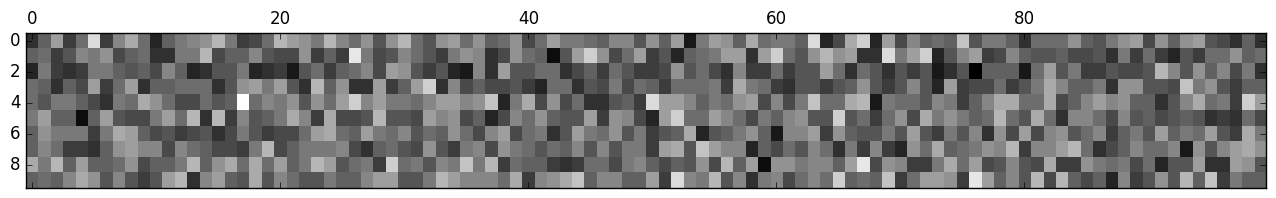

In [12]:
matshow(spikes', aspect="auto", cmap="gray");

Number of parameters
- $a$: 2$U$
- $\sigma$: 2
- $\eta$: 2$TU$

In [13]:
npars = U * VinDsl.num_pars_advi(RReal()) + VinDsl.num_pars_advi(RPositive()) +
T * U * VinDsl.num_pars_advi(RReal())
xx = 0.1 * randn(npars)
ELBO(xx)

-21631.47778954906

In [14]:
∇L = (storage, x) -> ForwardDiff.gradient!(storage, ELBO, x)
stor = similar(xx)
∇L(stor, xx)
@time ∇L(stor, xx)

  1.562912 seconds (8.04 M allocations: 679.587 MB, 6.21% gc time)


2022-element Array{Float64,1}:
    96.2983 
    38.2569 
  2615.62   
 -7682.52   
  -417.951  
  -374.225  
  -142.068  
   -58.1995 
   942.229  
  -725.058  
   273.02   
   -36.452  
   356.29   
     ⋮      
    17.0867 
   -16.259  
    20.1646 
    -3.70256
     4.73903
     3.36335
     5.88467
     7.44689
    13.5717 
    -6.19642
     8.93425
   -12.4798 

In [15]:
yy = copy(xx)
gg = similar(yy)
avg_sq_grad = similar(gg)
firstpass = true
elbo = Float64[];

In [16]:
step_size = 0.1
decay = 0.9
eps = 1e-8
nsteps = 160

for jj in 1:nsteps
    ∇L(gg, yy)
    nn = norm(gg)
    if nn/length(gg) > 10.
        gg /= norm(gg)  # crude gradient clipping
    end
    if firstpass == false
        avg_sq_grad = avg_sq_grad * decay + gg.^2 * (1 - decay)
    else
        avg_sq_grad = gg.^2
        firstpass = false
    end
    yy += step_size * gg ./(sqrt(avg_sq_grad) + eps)
    push!(elbo, ELBO(yy))
    display("Iteration $(length(elbo)) $(elbo[end])")
end

"Iteration 1 -21901.643192506774"

"Iteration 2 -21784.408566088663"

"Iteration 3 -22761.50851929847"

"Iteration 4 -20361.289769864685"

"Iteration 5 -21527.27940310702"

"Iteration 6 -17984.190834400826"

"Iteration 7 -17219.647018742507"

"Iteration 8 -20096.171998652517"

"Iteration 9 -15719.133230555724"

"Iteration 10 -14807.092746386164"

"Iteration 11 -14563.375832332598"

"Iteration 12 -14043.741827632271"

"Iteration 13 -13715.407754031177"

"Iteration 14 -12958.378054523191"

"Iteration 15 -11893.664828330544"

"Iteration 16 -11416.167999849515"

"Iteration 17 -10754.339545075985"

"Iteration 18 -10049.352149340006"

"Iteration 19 -9402.409352119079"

"Iteration 20 -9658.607301884787"

"Iteration 21 -8327.828020622168"

"Iteration 22 -8908.349523085642"

"Iteration 23 -7730.0682606714045"

"Iteration 24 -6830.5324054293405"

"Iteration 25 -7717.520227847391"

"Iteration 26 -6949.580812127499"

"Iteration 27 -6652.553936474353"

"Iteration 28 -5976.654400816284"

"Iteration 29 -6357.3658596257765"

"Iteration 30 -5812.548575407791"

"Iteration 31 -5490.162040191422"

"Iteration 32 -5059.303556650625"

"Iteration 33 -4781.426677334765"

"Iteration 34 -4551.261856632452"

"Iteration 35 -4308.270095528986"

"Iteration 36 -4292.079328215761"

"Iteration 37 -3994.083445482836"

"Iteration 38 -4023.492487795364"

"Iteration 39 -3941.4627487592675"

"Iteration 40 -3773.625767885166"

"Iteration 41 -3554.285420824762"

"Iteration 42 -3471.2177896320422"

"Iteration 43 -3606.801729149118"

"Iteration 44 -3458.755837296366"

"Iteration 45 -3312.558257314446"

"Iteration 46 -3422.1017210636055"

"Iteration 47 -3486.693965133956"

"Iteration 48 -3212.4499594516324"

"Iteration 49 -3295.4129262072634"

"Iteration 50 -2894.734068845817"

"Iteration 51 -3044.5778606475983"

"Iteration 52 -3043.3890236880393"

"Iteration 53 -3096.705300079607"

"Iteration 54 -2800.2168429386597"

"Iteration 55 -2823.6872893306668"

"Iteration 56 -2724.815827991035"

"Iteration 57 -2536.2819942592146"

"Iteration 58 -2813.8252996675283"

"Iteration 59 -2622.910766909394"

"Iteration 60 -2545.5242115244478"

"Iteration 61 -2716.8188182666395"

"Iteration 62 -2547.8211304211463"

"Iteration 63 -2487.1965455038285"

"Iteration 64 -2595.838009852493"

"Iteration 65 -2555.6287417482945"

"Iteration 66 -2496.6940447238594"

"Iteration 67 -2440.753239815258"

"Iteration 68 -2529.6677493249813"

"Iteration 69 -2342.0300345334454"

"Iteration 70 -2422.372643545843"

"Iteration 71 -2468.877089588612"

"Iteration 72 -2275.624680316577"

"Iteration 73 -2340.410675965846"

"Iteration 74 -2363.202887175471"

"Iteration 75 -2298.6586223903637"

"Iteration 76 -2424.8088286744824"

"Iteration 77 -2254.9648424563484"

"Iteration 78 -2256.767659962991"

"Iteration 79 -2268.489729925305"

"Iteration 80 -2321.730033369412"

"Iteration 81 -2263.3048735619204"

"Iteration 82 -2247.089332315065"

"Iteration 83 -2239.594407428411"

"Iteration 84 -2157.729730733962"

"Iteration 85 -2320.5130380270866"

"Iteration 86 -2181.973441053312"

"Iteration 87 -2151.7475185448898"

"Iteration 88 -2136.0583167507343"

"Iteration 89 -2207.967863877849"

"Iteration 90 -2213.9749887090247"

"Iteration 91 -2239.828309206509"

"Iteration 92 -2176.8503933645948"

"Iteration 93 -2127.587617212332"

"Iteration 94 -2206.123110053107"

"Iteration 95 -2096.1898543678385"

"Iteration 96 -2110.604683041632"

"Iteration 97 -2142.6319010119396"

"Iteration 98 -2072.0808398411173"

"Iteration 99 -2082.9017019162893"

"Iteration 100 -2067.3815735554995"

"Iteration 101 -2038.6749828045126"

"Iteration 102 -2008.7349778361252"

"Iteration 103 -2175.2734896075244"

"Iteration 104 -2163.3208904355224"

"Iteration 105 -2062.4252397849423"

"Iteration 106 -2027.6384133912975"

"Iteration 107 -2028.4687089222305"

"Iteration 108 -2092.8963261403974"

"Iteration 109 -2044.4750625303006"

"Iteration 110 -1980.050522057777"

"Iteration 111 -2059.126407304515"

"Iteration 112 -2016.3900277082657"

"Iteration 113 -1961.0534237732666"

"Iteration 114 -2076.216579276364"

"Iteration 115 -1965.2993420464118"

"Iteration 116 -2048.9245640823733"

"Iteration 117 -2052.929140493427"

"Iteration 118 -2007.0027668345772"

"Iteration 119 -1930.4442542333984"

"Iteration 120 -2060.5535192709685"

"Iteration 121 -1949.518181457218"

"Iteration 122 -1952.78904923031"

"Iteration 123 -2000.9738932013327"

"Iteration 124 -2099.798320407929"

"Iteration 125 -2093.411012505818"

"Iteration 126 -1966.694448941153"

"Iteration 127 -1943.7472773324391"

"Iteration 128 -2001.3031484555793"

"Iteration 129 -2032.0800170265766"

"Iteration 130 -1923.241793347899"

"Iteration 131 -1910.3122495794478"

"Iteration 132 -1996.2578334156574"

"Iteration 133 -1957.6409762797805"

"Iteration 134 -1951.2053297682116"

"Iteration 135 -1976.5174852613877"

"Iteration 136 -1908.6343265168282"

"Iteration 137 -1925.3980986570036"

"Iteration 138 -1887.3830020508765"

"Iteration 139 -1918.5944250428877"

"Iteration 140 -1991.5230883643699"

"Iteration 141 -2025.4096647444849"

"Iteration 142 -1925.7028873309512"

"Iteration 143 -1950.1036384208073"

"Iteration 144 -2057.729579572335"

"Iteration 145 -2017.467800560341"

"Iteration 146 -1859.708833399075"

"Iteration 147 -1888.4565974368297"

"Iteration 148 -1939.0910823624286"

"Iteration 149 -1948.19136384097"

"Iteration 150 -1919.7321499975917"

"Iteration 151 -1950.7692580396708"

"Iteration 152 -1890.3043823100202"

"Iteration 153 -1905.7101972997893"

"Iteration 154 -1888.98786569496"

"Iteration 155 -1905.1120590604025"

"Iteration 156 -1940.6845582157573"

"Iteration 157 -2026.209087976532"

"Iteration 158 -1931.0174026672742"

"Iteration 159 -1857.8731177192637"

"Iteration 160 -1905.7424392670107"

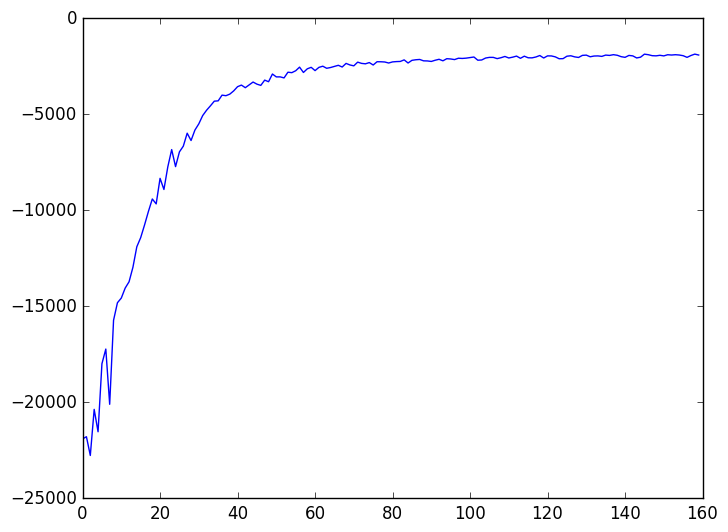

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x327bd7b50>

In [17]:
plot(elbo)

# Moving forward with ReverseDiff

- forward mode autodiff for $f: \mathbb{R}^n \rightarrow \mathbb{R}$ is $\mathcal{O}(n)$
- reverse mode is only $\mathcal{O}(1)$
- reverse mode lies behind Theano, TensorFlow, Stan

Once distributions are parametric, defining a new type that **just works** becomes easy
- same(-ish) idea as ForwardDiff.jl
- caveat: egregious memory usage

In [18]:
include("/Users/jmxp/code/rdiff/prototype6.jl")

backprop (generic function with 3 methods)

<img src="https://media.giphy.com/media/26AHLBZUC1n53ozi8/giphy.gif" width="400">

In [19]:
@time ∇L(stor, xx)
∇L_r = grad(ELBO, length(xx))
rstor = similar(xx)
∇L_r(xx, rstor);
@time ∇L_r(xx, rstor);

  1.447133 seconds (8.04 M allocations: 679.577 MB, 6.46% gc time)
  0.025645 seconds (155.60 k allocations: 5.186 MB)


# VinDsl needs your help!

![](http://cdn.badassdigest.com/uploads/images/30118/the_pacifier02crop__index.jpg)

Still finalizing API
- docs
- tests
- better ideas!
- Reverse mode!